<a href="https://colab.research.google.com/github/anjanidwilestari/PCVK_Genap_2023/blob/main/UAS_Anjani_Bella.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UAS PCVK TI-3E

Judul: Evaluasi Performa Teknik Klasifikasi Hyperparameter Tuning CNN pada Dataset CKPLUS

Anggota:
1. Anjani Dwilestari        2041720180/03
2. Bella Sonia Dwi Angelina 2041720063/04

LANGKAH 1 - SETUP

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
#akses drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LANGKAH 2 - PERSIAPAN DATASET

Load Data

In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/PCVK_AB/input/ck/"))

x = []
y = []
datadir = '/content/drive/MyDrive/PCVK_AB/CK+48'
Categories = []
for file_label in os.listdir(datadir):
    Categories.append(file_label)
    for file_name in os.listdir(datadir+'/'+file_label):
        x.append(datadir+'/'+file_label+'/'+file_name)
        y.append(file_label)

['CK+48', 'models', '.ipynb_checkpoints']


Split Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.20,random_state=34)

In [ ]:
print("x_train = ",len(x_train))
print("x_test = ",len(x_test))

x_train =  784
x_test =  197


In [ ]:
# os.mkdir('/content/drive/MyDrive/PCVK_AB/CK+48_Working/train')
# os.mkdir('/content/drive/MyDrive/PCVK_AB/CK+48_Working/test')

In [ ]:
# for file_label in Categories:
#     os.mkdir('/content/drive/MyDrive/PCVK_AB/CK+48_Working/test/'+file_label)
#     new='/content/drive/MyDrive/PCVK_AB/CK+48_Working/test/'+file_label
#     for file_name in x_test :
#         if(file_name.find(file_label))>0:
#             shutil.copy2(file_name, new)

In [ ]:
# for file_label in Categories:
#     os.mkdir('/content/drive/MyDrive/PCVK_AB/CK+48_Working/train/'+file_label)
#     new='/content/drive/MyDrive/PCVK_AB/CK+48_Working/train/'+file_label
#     for file_name in x_train :
#         if(file_name.find(file_label))>0:
#             shutil.copy2(file_name, new)

Augmentation & Normalization Data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Resize_pixelsize = 48
BS = 7

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(Resize_pixelsize,Resize_pixelsize),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/drive/MyDrive/PCVK_AB/CK+48_Working/train')
dev_generator  = get_datagen('/content/drive/MyDrive/PCVK_AB/CK+48_Working/test')

Found 784 images belonging to 7 classes.
Found 197 images belonging to 7 classes.


In [ ]:
label = train_generator.class_indices.keys()
print(label)

dict_keys(['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])


LANGKAH 3 - DEFINE MODEL

In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy

input_shape=(48,48,3)

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        
        model.add(Dense(128, activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(7, activation = 'softmax'))


        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [2, 7, 16, 32]),
            **kwargs,
        )

LANGKAH 4 - Instansiasi Tuner dan Lakukan Hypertuning

In [ ]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective="val_accuracy",
    overwrite=True,
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt',
)

Buat callback untuk menghentikan training lebih awal setelah mencapai nilai tertentu untuk validation loss.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Tuner search

In [ ]:
tuner.search(train_generator, epochs=50, validation_data=dev_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and The optimal batch size for the optimizer is {best_hps.get('batch_size')}
""")

Trial 18 Complete [00h 00m 40s]
val_accuracy: 0.9187816977500916

Best val_accuracy So Far: 0.9593908786773682
Total elapsed time: 00h 08m 38s

The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001 and The optimal batch size for the optimizer is 7



LANGKAH 5 - TRAIN MODEL

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_generator, epochs=50, validation_data=dev_generator)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
112/112 [==============================] - 8s 59ms/step - loss: 1.7792 - accuracy: 0.2972 - val_loss: 1.4386 - val_accuracy: 0.5127
Epoch 2/50
112/112 [==============================] - 5s 41ms/step - loss: 1.1738 - accuracy: 0.5651 - val_loss: 0.8171 - val_accuracy: 0.7056
Epoch 3/50
112/112 [==============================] - 6s 51ms/step - loss: 0.8033 - accuracy: 0.6964 - val_loss: 0.7249 - val_accuracy: 0.7563
Epoch 4/50
112/112 [==============================] - 4s 32ms/step - loss: 0.6092 - accuracy: 0.7819 - val_loss: 0.4451 - val_accuracy: 0.8426
Epoch 5/50
112/112 [==============================] - 4s 34ms/step - loss: 0.4944 - accuracy: 0.8138 - val_loss: 0.3783 - val_accuracy: 0.8883
Epoch 6/50
112/112 [==============================] - 6s 54ms/step - loss: 0.3406 - accuracy: 0.8839 - val_loss: 0.2608 - val_accuracy: 0.9239
Epoch 7/50
112/112 [==============================] - 4s 34ms/step - loss: 0.2584 - accuracy: 0.9107 - val_loss: 0.1997 - val_accuracy: 0.9239

Instansiasi ulang hypermodel dan latih dengan jumlah epoch optimal dari atas

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_generator, epochs=best_epoch, validation_data=dev_generator)

Epoch 1/41
112/112 [==============================] - 7s 55ms/step - loss: 1.7574 - accuracy: 0.3367 - val_loss: 1.2852 - val_accuracy: 0.4975
Epoch 2/41
112/112 [==============================] - 4s 31ms/step - loss: 1.1502 - accuracy: 0.5765 - val_loss: 0.9187 - val_accuracy: 0.6650
Epoch 3/41
112/112 [==============================] - 5s 46ms/step - loss: 0.8451 - accuracy: 0.6913 - val_loss: 0.6471 - val_accuracy: 0.7310
Epoch 4/41
112/112 [==============================] - 4s 40ms/step - loss: 0.6261 - accuracy: 0.7628 - val_loss: 0.5010 - val_accuracy: 0.7919
Epoch 5/41
112/112 [==============================] - 7s 60ms/step - loss: 0.5252 - accuracy: 0.8112 - val_loss: 0.4111 - val_accuracy: 0.8376
Epoch 6/41
112/112 [==============================] - 4s 34ms/step - loss: 0.4180 - accuracy: 0.8482 - val_loss: 0.3497 - val_accuracy: 0.8629
Epoch 7/41
112/112 [==============================] - 6s 51ms/step - loss: 0.3141 - accuracy: 0.8954 - val_loss: 0.2627 - val_accuracy: 0.9137

Evaluasi hypermodel dengan data test

In [ ]:
eval_result = hypermodel.evaluate(dev_generator)
print("[test loss, test accuracy]:", eval_result)

29/29 [==============================] - 1s 17ms/step - loss: 0.0754 - accuracy: 0.9746
[test loss, test accuracy]: [0.07538267970085144, 0.9746192693710327]


LANGKAH 6 - MEMPERSIAPKAN MODEL UNTUK PREDIKSI

Menyimpan Model

In [ ]:
batch_size_str = '-BS_' + str(best_hps.get('batch_size'))
learning_rate_str = '-LR_' + str(best_hps.get('learning_rate'))
epoch_str = '-EPOCHS_' + str(best_epoch)
test_acc = 'test_acc_%.3f' % eval_result[1]
model.save('/content/drive/MyDrive/PCVK_AB/CK+48_Working/models/' + 'Sequential' + epoch_str + batch_size_str + learning_rate_str + test_acc + '.h5')

Load Model

In [ ]:
# Loading the best fit model 
from keras.models import load_model
model = load_model('/content/drive/MyDrive/PCVK_AB/CK+48_Working/models/Sequential-EPOCHS_41-BS_7-LR_0.001test_acc_0.975.h5')

In [ ]:
# just to map o/p values 
op = dict(zip( train_generator.class_indices.values(), train_generator.class_indices.keys()))

1/1 [==============================] - 0s 31ms/step
 the image is of fear


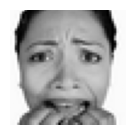

In [ ]:
# path for the image to see if it predics correct class
from keras.utils import img_to_array, load_img

path = "/content/drive/MyDrive/PCVK_AB/Emotion Detection/test/fearful/im139.png"
img = load_img(path, target_size=(48,48) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# Buat plot dengan ukuran 150x150 piksel
plt.figure(figsize=(1.5, 1.5), dpi=100)  # ukuran figur dalam inches (1 inch = 100 piksel)

# Tampilkan gambar dengan ukuran 150x150 piksel
plt.imshow(input_arr[0], extent=[0, 150, 0, 150])

# Hapus sumbu
plt.axis('off')

# Tampilkan plot
plt.show()